In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import fun.net as net
print(tf.config.list_physical_devices('GPU'))  # 确认GPU可用 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# According to https://blog.csdn.net/hxj0323/article/details/121629067
# Implement GPU memory allocation according to demand
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0 :
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("Got no GPUs")

In [3]:
N_train = 6000 
N_test = 6000
N_val = 6000

dab = 320 
dt = 0.4   

PROBE_A = 0
PROBE_B = 1

state = 'state4'
data_path = 'data/hos-nwt-state4-probs-360.npy'
Hs = 1.88


In [4]:
TIME_END = 20 
EARLY_STOPPING = 300
patience = 0.0001  # patience in early stopping

batch_size = 256
learning_rate = 0.0001

# dt = 0.4 s, so t_a = inputs_shape * dt = 160 s
# dx = 1.92 m,so d_bc = output_shape * dx = 672 m
inputs_shape = 800 # 
output_shape = 350 # 

act_f_list = ['relu', 'elu',]


w_init = tf.keras.initializers.GlorotUniform

time_now = time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())).replace(' ', '-').replace(':', '-')

name_base = state 

space_name = 'PZWP' 


In [5]:
# load data 
x_test = np.load('data/x_test.npy',)
x_train = np.load('data/x_train.npy',)
x_val = np.load('data/x_val.npy',)

y_test = np.load('data/y_test.npy',)
y_train = np.load('data/y_train.npy',)
y_val_label = np.load('data/y_val.npy',)

model nameL: state4-sn-0-p-train-800-output-350-actf-relu-2024-03-02-11-41-30
0
0.0033581137188389448
0.003359317
674


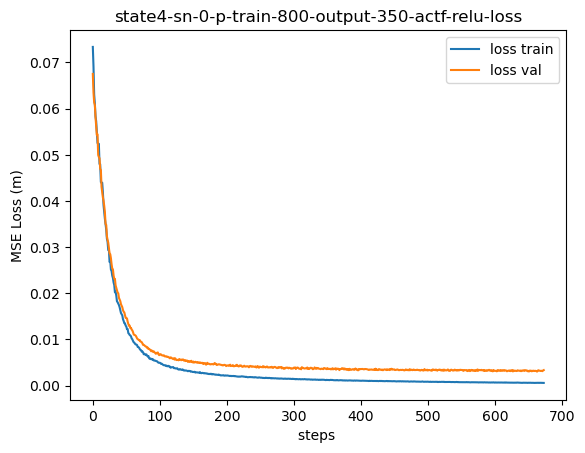

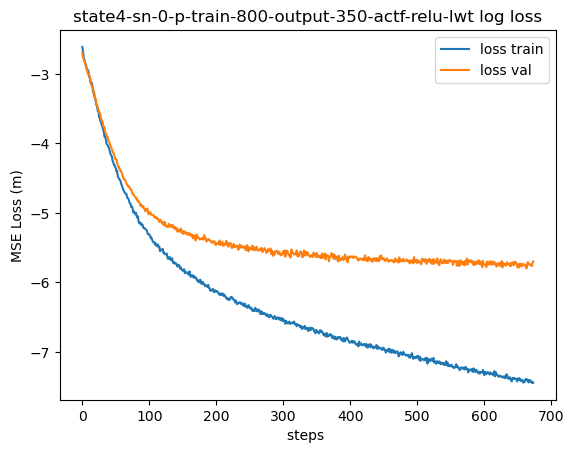

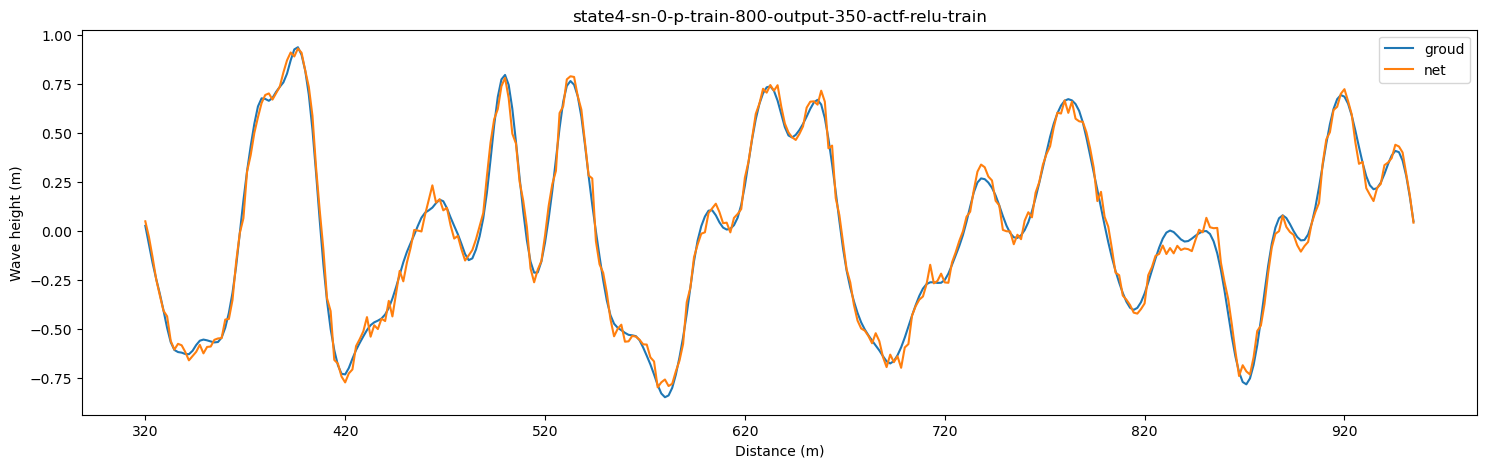

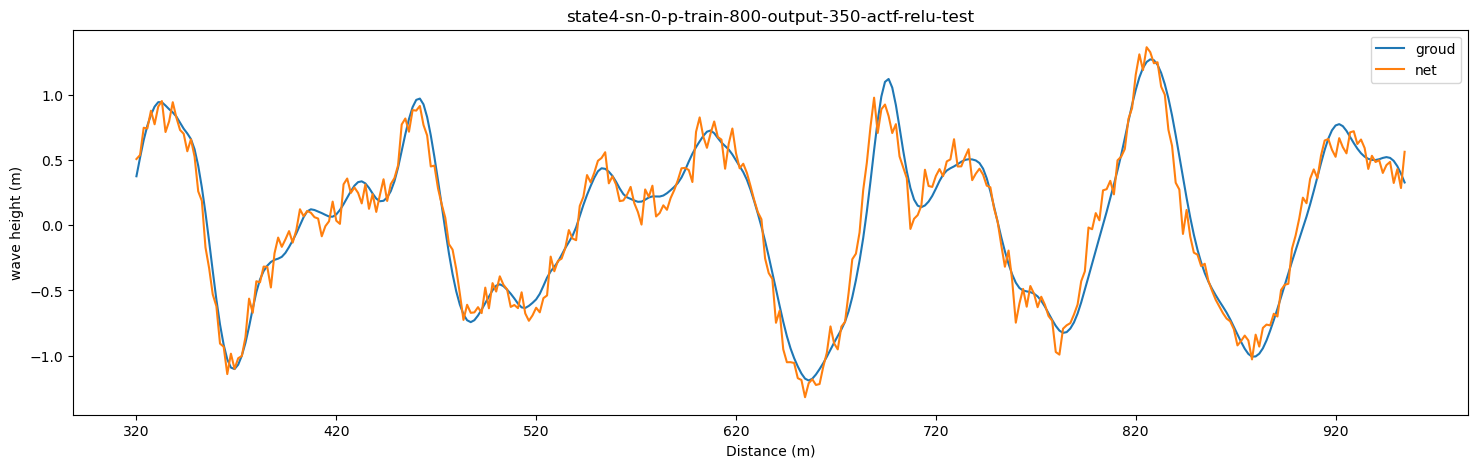

model nameL: state4-sn-1-p-train-800-output-350-actf-elu-2024-03-02-11-41-30
1
0.0015597180288166655
0.0015621871
362


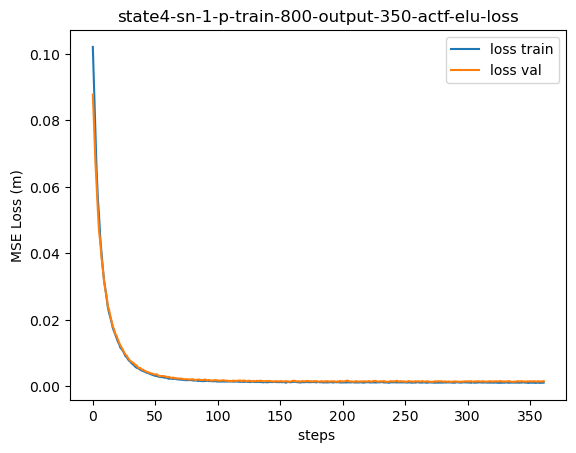

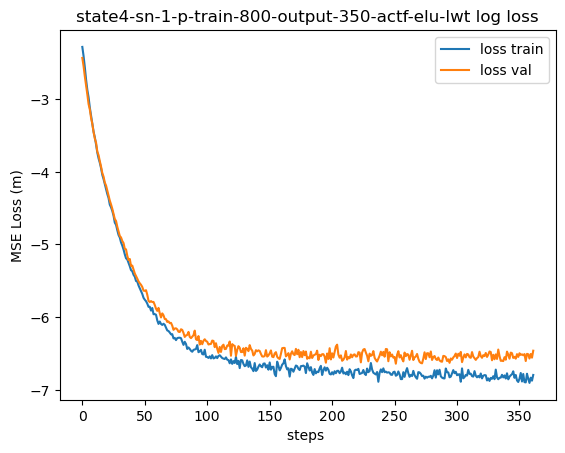

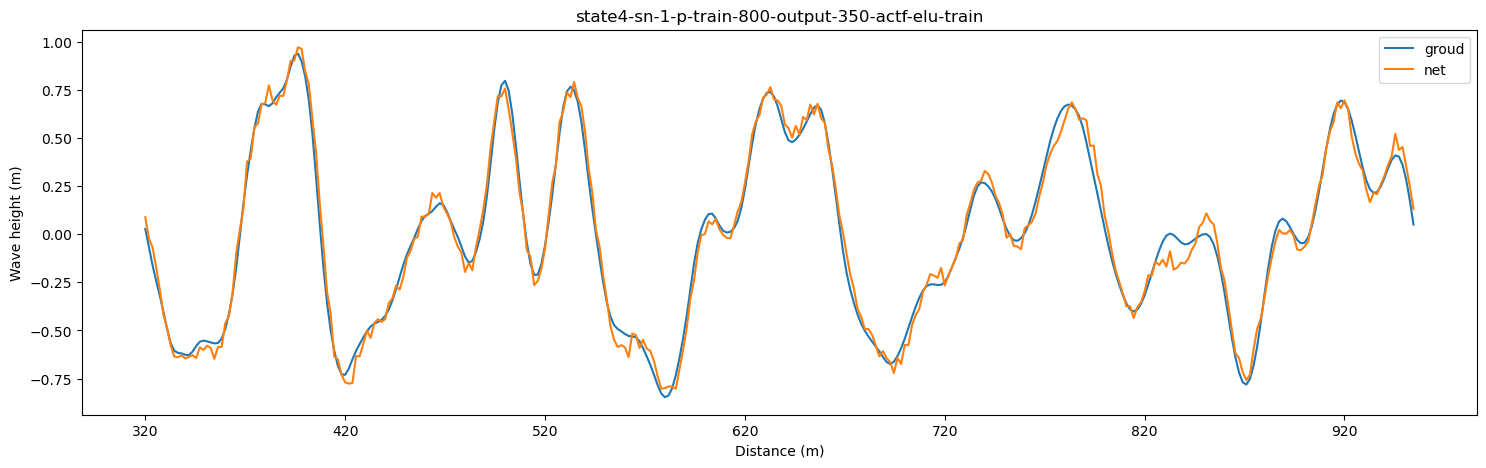

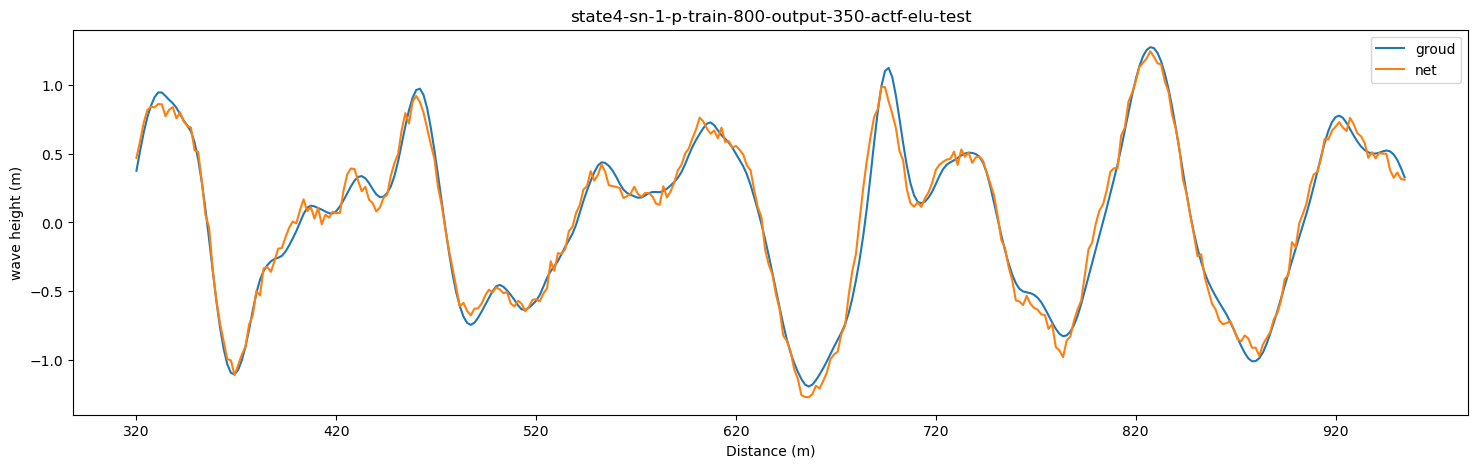

In [6]:
for sn, act_f in enumerate(act_f_list):
    # set model 
    name =  name_base +'-sn-' + str(sn) + '-p-train-' + str(inputs_shape) + '-output-' + str(output_shape) + '-actf-' + act_f  
    MODEL_NAME = name  + '-' + time_now

    print("model nameL:", MODEL_NAME, )
    SAVE_PATH =  './models/' + space_name+ '/' +MODEL_NAME
    
    mlp = net.Mlp([inputs_shape, int(inputs_shape*3),int(inputs_shape*3),  output_shape], act_fun=act_f, w_init=w_init)
    ckpt = tf.train.Checkpoint(step=tf.Variable(0), net=mlp)
    manager = tf.train.CheckpointManager(ckpt, SAVE_PATH, max_to_keep=3)
    op_adam = tf.keras.optimizers.Adam(learning_rate)

    # set tensorboard 
    TRAIN_LOG_DIR = './logs/' +space_name+ '/'+ MODEL_NAME + '/train'
    VAL_LOG_DIR = './logs/' +space_name+ '/'+ MODEL_NAME + '/val'
    train_summary_writer = tf.summary.create_file_writer(TRAIN_LOG_DIR)
    val_summary_writer = tf.summary.create_file_writer(VAL_LOG_DIR)

    time_end = TIME_END 
    i = 0 
    time_start = time.time()
    loss_train_list = []
    loss_val_list = []

    while time.time() - time_start < time_end:

            with tf.GradientTape(persistent=True) as tape:

                index = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
                index = np.unique(index)

                # index = slice(index)
                y = mlp(x_train[index, :])

                loss = tf.reduce_mean(tf.square(y_train[index, :] - y))
                e_gradients = tape.gradient(loss, mlp.trainable_variables)
                op_adam.apply_gradients(zip(e_gradients, mlp.trainable_variables))

            del tape
            loss_train_list.append(loss.numpy())

            index_val = np.random.randint(low=0, high=x_val.shape[0], size=batch_size)
            index_val = np.unique(index_val)
            # index_val = slice(index_val)    
            y_valid = mlp(x_val[index_val, :])

            loss_valid = tf.reduce_mean(tf.square(y_valid - y_val_label[index_val, :])) 
            loss_val_list.append(loss_valid.numpy())
            
            # early stopping part 
            if patience + len(loss_val_list)>300 and sum(loss_val_list[-EARLY_STOPPING:-1])/len(loss_val_list[-EARLY_STOPPING:-1]) < loss_valid.numpy():
                print(sn)
                print(sum(loss_val_list[-EARLY_STOPPING:-1])/len(loss_val_list[-EARLY_STOPPING:-1]))
                print(loss_valid.numpy())
                print(len(loss_val_list))
                time_end = 0 

            # save loss  
            with train_summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=i)
             
            with val_summary_writer.as_default():
                tf.summary.scalar('loss', loss_valid, step=i)
               
            i = i + 1 

    # save model
    # save_path = manager.save()

    y_test_net = mlp(x_test)
    loss_test = tf.reduce_mean(tf.square(y_test_net*Hs - y_test*Hs), axis=0)

    y_train_net = mlp(x_train)
    
    # show loss 
    xticks = np.arange(len(loss_train_list))
    plt.plot(xticks, loss_train_list)
    plt.plot(xticks, loss_val_list)
    plt.xlabel('steps ')
    plt.ylabel('MSE Loss (m)')
    plt.title(name + '-loss')
    plt.legend(['loss train', 'loss val'])
    plt.show()

    # show log loss
    xticks = np.arange(len(loss_train_list))
    plt.plot(xticks, np.log(loss_train_list))
    plt.plot(xticks, np.log(loss_val_list))
    plt.xlabel('steps ')
    plt.ylabel('MSE Loss (m)')
    plt.title(name + '-lwt log loss')
    plt.legend(['loss train', 'loss val'])
    plt.show()

    y = mlp(x_train)
    t = np.arange(output_shape)
    num = 1 
    plt.figure(figsize=(18, 5))
    plt.plot(t, y_train[num, :]*Hs)
    plt.plot(t, y[num, :]*Hs)
    plt.legend(['groud', 'net'])
    plt.title(name + '-train')
    plt.xlabel('Distance (m)')
    plt.ylabel('Wave height (m)')
    plt.xticks([0, 55, 110, 165, 220, 275, 330], np.array([0, 100, 200, 300, 400, 500, 600]) + dab,)
    # plt.xticks([0, 241, 482, 723, 964, 1250], [0, 100, 200, 300, 400, 500])
    plt.show()

    y = mlp(x_test)
    t = np.arange(output_shape)
    num = 29 
    plt.figure(figsize=(18, 5))
    plt.plot(t, y_test[num, :]*Hs)
    plt.plot(t, y[num, :]*Hs)
    plt.legend(['groud', 'net'])
    plt.title(name + '-test')
    plt.xlabel('Distance (m)')
    plt.ylabel('wave height (m)')
    plt.xticks([0, 55, 110, 165, 220, 275, 330], np.array([0, 100, 200, 300, 400, 500, 600]) + dab,)
    plt.show()
